In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()
adata

C:\Users\denni\anaconda3\envs\bioinformatics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8
... reading from cache file cache\data-filtered_gene_bc_matrices-hg19-matrix.h5ad


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

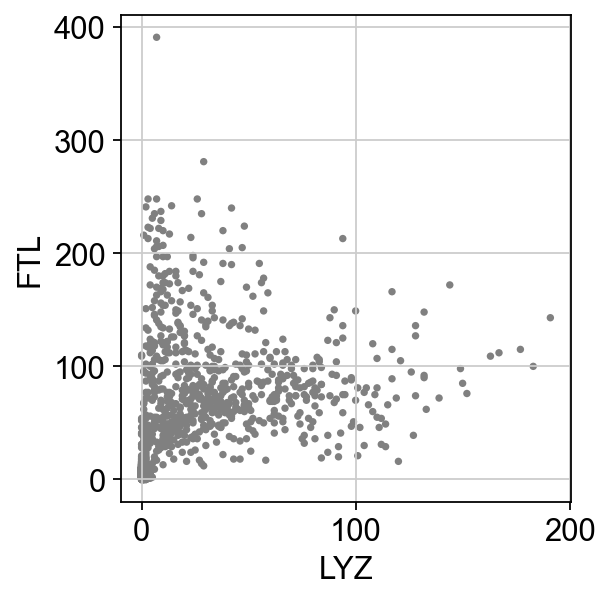

In [2]:
#x-axis = counts of LYZ transcript and y = same for FTL, dots=cells, so a dot at (100,100) is a cell with 100 molecules of each transcript
sc.pl.scatter(adata, x='LYZ', y='FTL') #raw counts, completely unfiltered
#Can save raw counts for later use using: 
# adata.layers["counts"] = adata.X.copy()
#Access later using:
# adata.X = adata.layers["counts"].copy()

In [3]:
#maybe don't do all this filtering?
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3) 

filtered out 19024 genes that are detected in less than 3 cells


In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [5]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [6]:
adata.layers["counts"] = adata.X.copy()

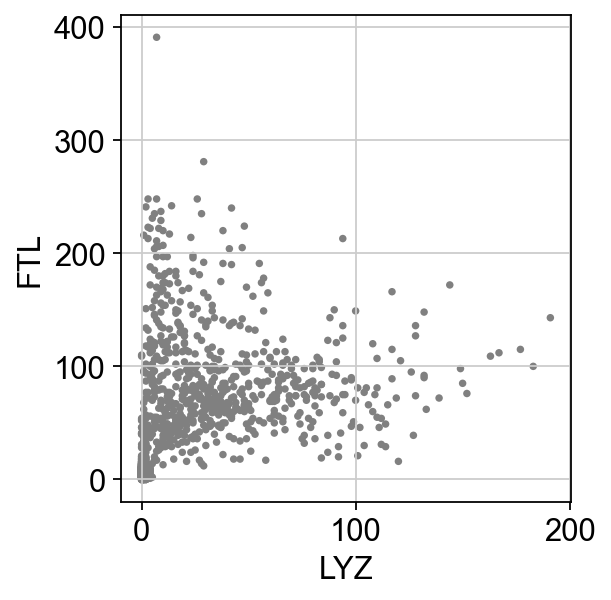

In [7]:
sc.pl.scatter(adata, x='LYZ', y='FTL') #Raw counts, minimally filtered

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [9]:
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=5000)
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=10, min_disp=0.1)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


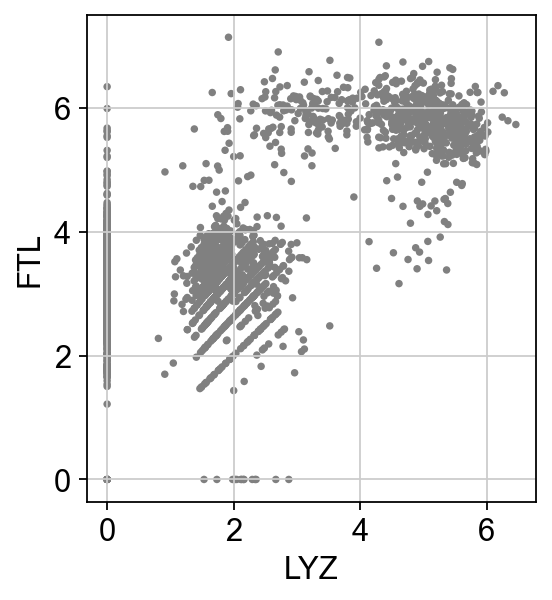

In [10]:
sc.pl.scatter(adata, x='LYZ', y='FTL') #Normalized, minimally filtered

In [11]:
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [12]:
adata = adata[:, adata.var.highly_variable]

In [13]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


In [14]:
sc.pp.scale(adata, max_value=10)
adata

AnnData object with n_obs × n_vars = 2638 × 3130
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [15]:
#PCA 
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [16]:
#Clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [17]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [18]:
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_2")

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_2', the cluster labels (adata.obs, categorical) (0:00:00)


In [19]:
sc.tl.rank_genes_groups(adata, 'leiden_2', method='logreg')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:05)


C:\Users\denni\anaconda3\envs\bioinformatics\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


|Cluster ID	|Markers         |Cell Type       |
|-----------|----------------|----------------|
|0	        |IL7R,S100A4     |Memory CD4+     |
|1	        |CD14,LYZ	     |CD14+ Mono      |
|2	        |IL7R,CCR7	     |Naive CD4+ T    |
|3	        |MS4A1	         |B               |
|4	        |CD8A	         |CD8+ T          |
|5	        |FCGR3A,MS4A7	 |FCGR3A+         |
|6	        |GNLY,NKG7	     |NK              |
|7	        |FCER1A,CST3     |Dendritic C     |
|8	        |PPBP	         |Megakaryocytes  |

(cluster ID column is from Seurat, so in your case, match Markers with cell types, by getting the markers for each cluster!
 The point of doing this is as a clustering sanity check)

In [20]:
new_cluster_names = [
    'Memory CD4+', 'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'FCGR3A Monocytes', 'NK',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden_2', new_cluster_names)

C:\Users\denni\anaconda3\envs\bioinformatics\lib\site-packages\anndata\_core\anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


In [21]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,Memory CD4+,CD4 T,CD14 Monocytes,B,CD8 T,FCGR3A Monocytes,NK,Dendritic,Megakaryocytes
0,IL32,AIF1,S100A9,CD79A,CCL5,FCGR3A,GNLY,FCER1A,PPBP
1,LTB,CD7,S100A8,HLA-DRA,NKG7,IFITM2,GZMB,HLA-DQA1,PF4
2,KLF6,RGS10,LYZ,CD74,GZMK,LST1,TYROBP,HLA-DQB1,GNG11
3,S100A4,CD8B,LGALS2,MS4A1,CST7,MS4A7,NKG7,CLEC10A,SDPR
4,TRADD,CCR7,FCN1,HLA-DPB1,GZMA,IFITM3,FGFBP2,CST3,GPX1


C:\Users\denni\anaconda3\envs\bioinformatics\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


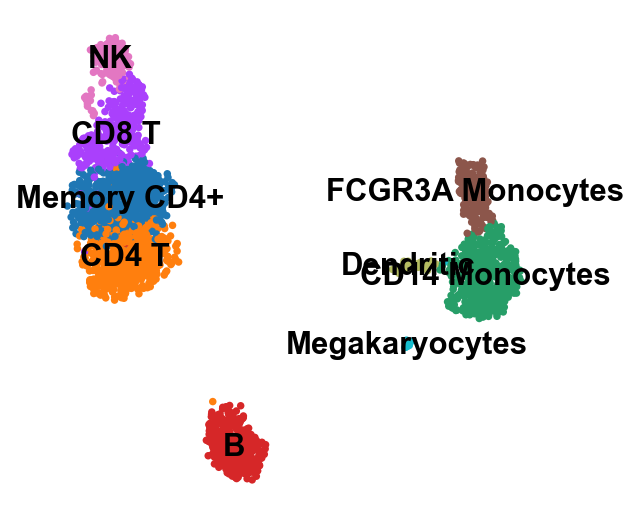

In [22]:
sc.pl.umap(adata, color='leiden_2', legend_loc='on data', title='', frameon=False, save='.pdf')

In [23]:
def get_column(adata_instance, X, goi):
    goi_id = adata_instance.var.gene_ids[goi]
    goi_index = (adata_instance.var.gene_ids==goi_id).argmax()
    return X[:, goi_index] 

def highly_coexpressed(goi, cell_type=None):
    if cell_type == None:
        X = adata.X
    else:
        #run on subset
        X = adata.X[adata.obs.leiden_2 == cell_type]

    corr_X = np.corrcoef(np.transpose(X)) 
    goi_corr_col = get_column(adata, corr_X, goi)
    indices = np.argsort(goi_corr_col)
    n = indices.shape[0]
    indices_top_20 = np.flip(indices[n-21: n]) 
    temp = adata.var.gene_ids[indices_top_20].keys()
    d = {'Genes': adata.var.gene_ids[indices_top_20].keys(), 'Pearson Coefficients': goi_corr_col[indices_top_20]}
    df =  pd.DataFrame(data=d)
    return df

def pairwise_expression(goi_1, goi_2, cell_type=None):
    if cell_type == None:
        X = adata.X
    else:
        #run on subset
        X = adata.X[adata.obs.leiden_2 == cell_type]
    
    goi_1_col = get_column(adata, X, goi_1)
    goi_2_col = get_column(adata, X, goi_2)
    
    pw_corr = np.corrcoef(goi_1_col, goi_2_col)
    return pw_corr

In [24]:
res = highly_coexpressed('LYZ')
res

,Genes,Pearson Coefficients
0,LYZ,1.000000
1,S100A9,0.799024
2,S100A8,0.779052
3,CST3,0.770817
4,FCN1,0.744636
5,LGALS2,0.742420
6,TYROBP,0.722963
7,FTL,0.691273
8,AIF1,0.678401
9,LST1,0.674861


In [25]:
res2 = highly_coexpressed('LYZ', 'CD14 Monocytes')
res2

,Genes,Pearson Coefficients
0,LYZ,1.000000
1,ZRANB3,0.599436
2,VIL1,0.597468
3,FAM109B,0.594260
4,RP11-413H22.2,0.585936
5,SEC61A2,0.585805
6,C1orf112,0.584084
7,GSTA4,0.569317
8,RP11-545I5.3,0.569165
9,PPAPDC2,0.566571


In [26]:
pairwise_expression('LYZ', 'FTL') #It makes sense, it is the correlation between two vectors, outta be a number

array([[1.        , 0.69127323],
       [0.69127323, 1.        ]])

In [27]:
#Change adata to only include the monocyte rows!
pairwise_expression('LYZ', 'FTL', 'CD14 Monocytes')

array([[1.        , 0.33444492],
       [0.33444492, 1.        ]])

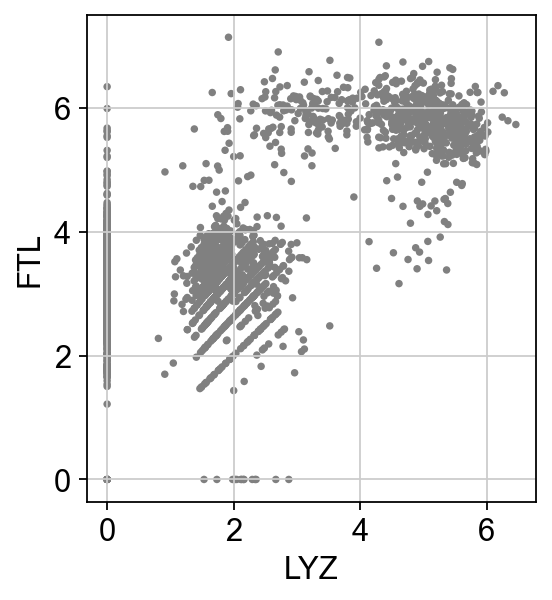

In [28]:
adata.X = adata.layers["counts"].copy()
sc.pl.scatter(adata, x='LYZ', y='FTL', use_raw=True) #Should recover OG plot, if using raw will plot log normalised values (which is what should be submitted!)

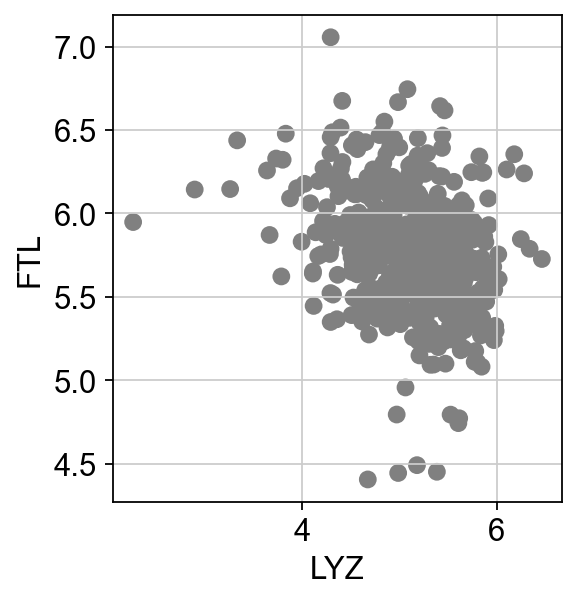

In [29]:
bdata = adata[adata.obs.leiden_2 == "CD14 Monocytes"] #Would be helpful to rename leiden_2 col to cell_type!
sc.pl.scatter(bdata, x='LYZ', y='FTL', use_raw=True)